In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
from shutil import copyfile

import numpy as np
from sklearn.model_selection import train_test_split
from shutil import rmtree

In [3]:
#rmtree('train') # Remove existing, if re-run
#rmtree('test') # Remove existing, if re-run

os.makedirs('/content/drive/MyDrive/pneumonia_resnet152/train/NORMAL', exist_ok=True)
os.makedirs('/content/drive/MyDrive/pneumonia_resnet152/train/PNEUMONIA', exist_ok=True)
os.makedirs('/content/drive/MyDrive/pneumonia_resnet152/test/NORMAL', exist_ok=True)
os.makedirs('/content/drive/MyDrive/pneumonia_resnet152/test/PNEUMONIA', exist_ok=True)

In [4]:
# Split NORMAL
train, test = train_test_split(os.listdir('/content/drive/MyDrive/pneumonia/images/NORMAL'), 
                               test_size=0.2, 
                               random_state=42)

In [ ]:

for img in train:
    copyfile(os.path.join('/content/drive/MyDrive/pneumonia/images/NORMAL/', img), 
             os.path.join('/content/drive/MyDrive/pneumonia_resnet152/train/NORMAL/', img))
for img in test:
    copyfile(os.path.join('/content/drive/MyDrive/pneumonia/images/NORMAL/', img), 
             os.path.join('/content/drive/MyDrive/pneumonia_resnet152/test/NORMAL/', img))

In [5]:
# Split PNEUMONIA
train, test = train_test_split(os.listdir('/content/drive/MyDrive/pneumonia/images/PNEUMONIA'), 
                               test_size=0.2, 
                               random_state=42)

In [ ]:
for img in train:
    copyfile(os.path.join('/content/drive/MyDrive/pneumonia/images/PNEUMONIA/', img), 
             os.path.join('/content/drive/MyDrive/pneumonia_resnet152/train/PNEUMONIA/', img))
for img in test:
    copyfile(os.path.join('/content/drive/MyDrive/pneumonia/images/PNEUMONIA/', img), 
             os.path.join('/content/drive/MyDrive/pneumonia_resnet152/test/PNEUMONIA/', img))

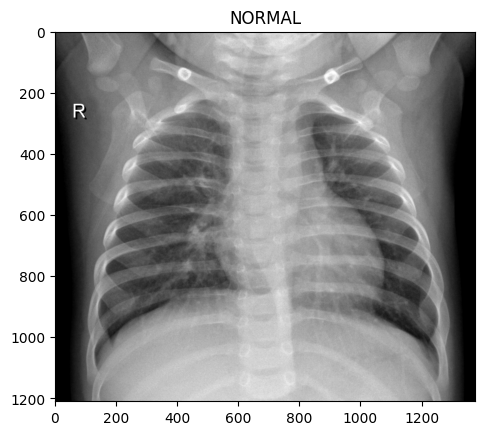

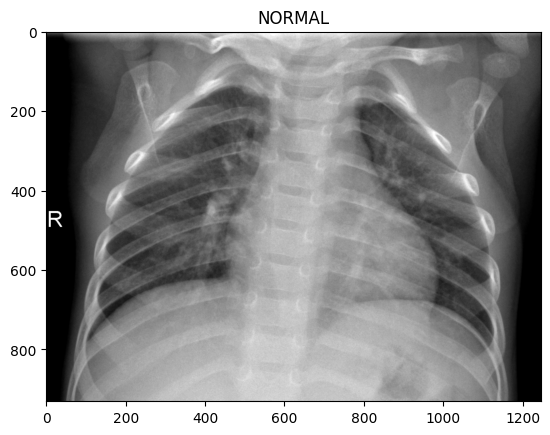

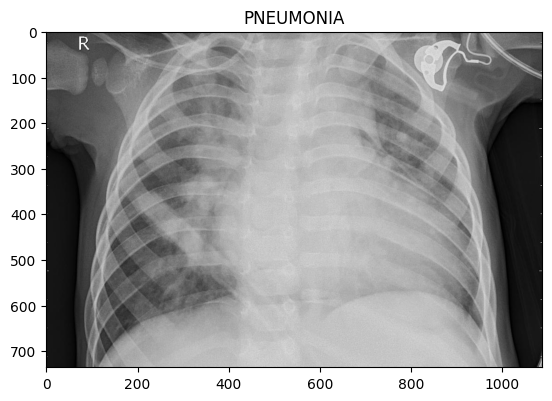

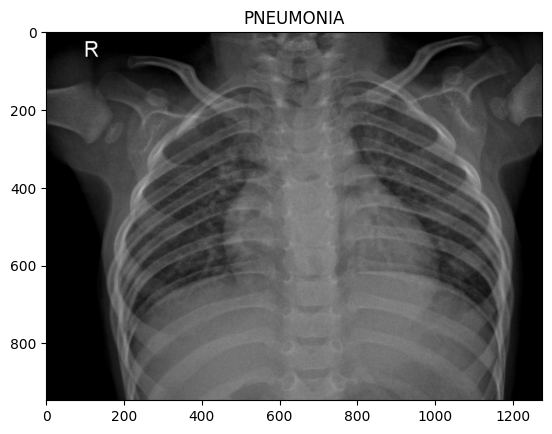

In [6]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

for dirname, _, filenames in os.walk('/content/drive/MyDrive/pneumonia_resnet152/train/'):
    for i, file in enumerate(filenames):
        if(i > 1):
            break
        plt.imshow(mpimg.imread(os.path.join(dirname, file)), cmap='gray')
        plt.title(dirname.split('/')[6])
        
        plt.show()



In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

SIZE = 224
BATCH = 16

# image augmentations
image_gen = ImageDataGenerator(rescale=1./255,
                                rotation_range=5,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                validation_split=0.2)

# flow_from_directory generators
train_generator = image_gen\
    .flow_from_directory('/content/drive/MyDrive/pneumonia_resnet152/train',
                        target_size=(SIZE, SIZE),
                        class_mode="binary",
                        batch_size=BATCH,
                        subset='training')

validation_generator = image_gen\
    .flow_from_directory('/content/drive/MyDrive/pneumonia_resnet152/train',
                        target_size=(SIZE, SIZE),
                        class_mode="binary",
                        batch_size=BATCH,
                        subset='validation')

Found 4011 images belonging to 2 classes.
Found 1002 images belonging to 2 classes.


In [12]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet152
from tensorflow.keras.callbacks import Callback
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D,Dropout
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.metrics import Recall, Precision

In [17]:


# Callbacks
mc = ModelCheckpoint('/content/drive/MyDrive/pneumonia_resnet152/resnet152_model.hdf5', 
                     save_best_only=True, 
                     verbose=0, 
                     monitor='val_loss', 
                     mode='min')

## Reduce learning rate if it gets stuck in a plateau
rlr = ReduceLROnPlateau(monitor='val_loss', 
                        factor=0.3, 
                        patience=3, 
                        min_lr=0.000001, 
                        verbose=1)
## Keep the best model
mc = ModelCheckpoint('/content/drive/MyDrive/pneumonia_resnet152/resnet152_model.hdf5', #################
                     save_best_only=True, 
                     verbose=0, 
                     monitor='val_loss', 
                     mode='min')

# Model
## Define the base model with EfficientNet weights
model = ResNet152(weights = 'imagenet', 
                           include_top = False, 
                           input_shape = (SIZE, SIZE, 3))

## Output layer
x = model.output
x = GlobalAveragePooling2D()(x)

x = Dense(128, activation="relu")(x)         ###AURO-- Dense(128) * 2  64,32
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x= Dropout(0.5)(x)                          ###Auro - None
predictions = Dense(1, activation="sigmoid")(x)

## Compile and run
model = Model(inputs=model.input, outputs=predictions)





234698864/234698864 [==============================] - 10s 0us/step


In [18]:
model.compile(optimizer='adam',
              loss='binary_crossentropy', 
              metrics=['accuracy', Recall(), Precision()])

In [ ]:
# steps_per_epoch=3 try once

In [19]:
model_history = model.fit(train_generator,validation_data=validation_generator,epochs=50,verbose=1,callbacks=[mc,rlr])

Epoch 1/50
251/251 [==============================] - 313s 757ms/step - loss: 0.3391 - accuracy: 0.8741 - recall_1: 0.9328 - precision_1: 0.9018 - val_loss: 72.4412 - val_accuracy: 0.7465 - val_recall_1: 1.0000 - val_precision_1: 0.7465 - lr: 0.0010
Epoch 2/50
251/251 [==============================] - 181s 721ms/step - loss: 0.2285 - accuracy: 0.9237 - recall_1: 0.9619 - precision_1: 0.9375 - val_loss: 77.1018 - val_accuracy: 0.7465 - val_recall_1: 1.0000 - val_precision_1: 0.7465 - lr: 0.0010
Epoch 3/50
251/251 [==============================] - 188s 748ms/step - loss: 0.2225 - accuracy: 0.9262 - recall_1: 0.9509 - precision_1: 0.9503 - val_loss: 0.9994 - val_accuracy: 0.1936 - val_recall_1: 0.0642 - val_precision_1: 0.3077 - lr: 0.0010
Epoch 4/50
251/251 [==============================] - 169s 673ms/step - loss: 0.1934 - accuracy: 0.9347 - recall_1: 0.9669 - precision_1: 0.9467 - val_loss: 3.8875 - val_accuracy: 0.7465 - val_recall_1: 1.0000 - val_precision_1: 0.7465 - lr: 0.0010
Ep

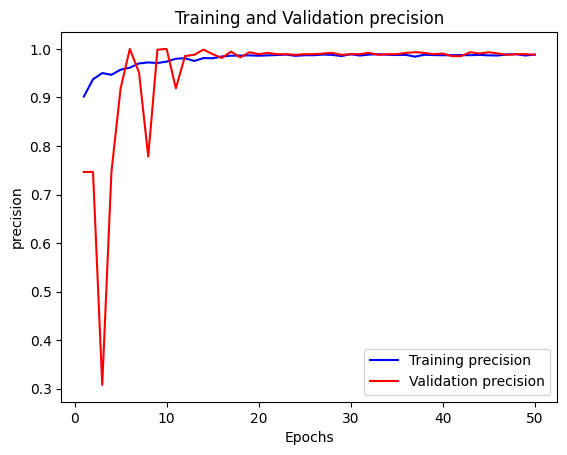

In [22]:
train_precision = model_history.history['precision_1']
val_precision = model_history.history['val_precision_1']
epochs = range(1, len(train_precision) + 1)

# Plot the loss vs. epoch graph
plt.plot(epochs, train_precision, 'b', label='Training precision')
plt.plot(epochs, val_precision, 'r', label='Validation precision')
plt.title('Training and Validation precision')
plt.xlabel('Epochs')
plt.ylabel('precision')
plt.legend()
plt.show()

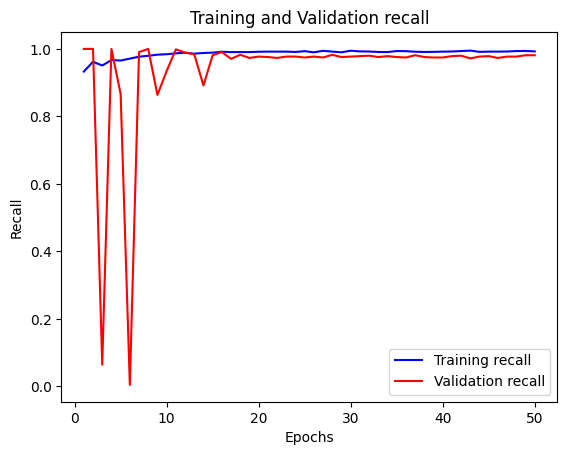

In [24]:
train_recall = model_history.history['recall_1']
val_recall = model_history.history['val_recall_1']
epochs = range(1, len(train_recall) + 1)

# Plot the loss vs. epoch graph
plt.plot(epochs, train_recall, 'b', label='Training recall')
plt.plot(epochs, val_recall, 'r', label='Validation recall')
plt.title('Training and Validation recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()

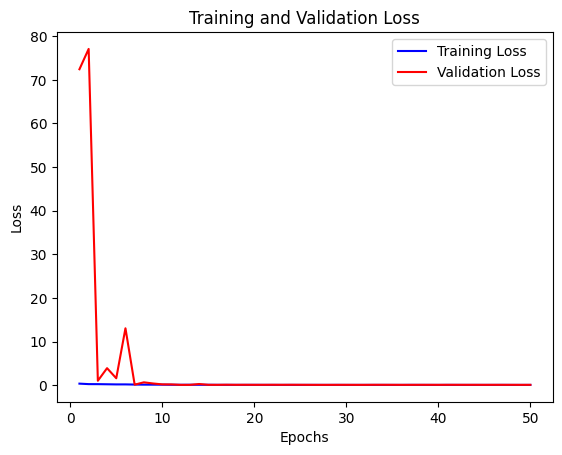

In [25]:
train_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plot the loss vs. epoch graph
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

<Figure size 640x480 with 0 Axes>

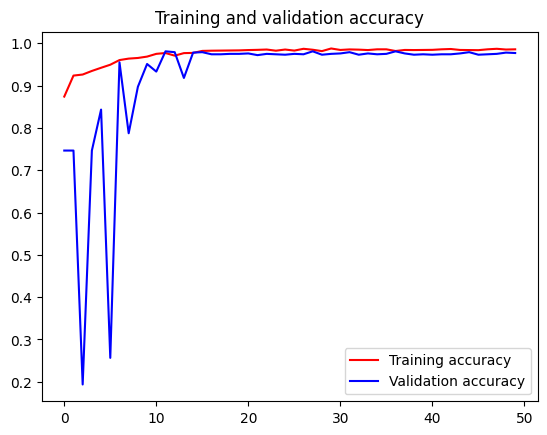

<Figure size 640x480 with 0 Axes>

In [27]:
# Plot training and validation accuracy by epoch
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

In [28]:
# Load the best model
# model.save("/content/drive/MyDrive/pneumonia_resnet152/resnet152_model.hdf5")
model.load_weights("/content/drive/MyDrive/pneumonia_resnet152/resnet152_model.hdf5")

In [ ]:
model.summary()

In [1]:
# summary = {
#     'Feature': ['Intercept'] + list(X_train.columns),
#     'Coefficient': [model.intercept_] + list(model.coef_)
# }

# # Convert summary to tabular format
# import pandas as pd
# summary_table = pd.DataFrame(summary)

# # Print or display the model summary
# print(summary_table)

In [29]:
test_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range=5,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1)

test_generator = test_datagen.flow_from_directory(
    directory="/content/drive/MyDrive/pneumonia_resnet152/test",
    target_size=(SIZE, SIZE),
    class_mode="binary",
    shuffle=False,
    batch_size=BATCH
)

preds = model.predict(test_generator) # get proba predictions
labels = 1*(preds > 0.5) # convert proba to classes


Found 1172 images belonging to 2 classes.
74/74 [==============================] - 506s 7s/step


In [30]:
print(preds)

[[0.00412861]
 [0.02283102]
 [0.01969825]
 ...
 [0.99999344]
 [1.        ]
 [0.9998635 ]]


In [31]:
 pip install mlxtend

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


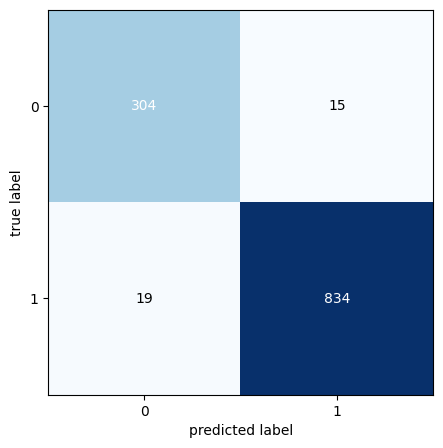

In [32]:
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix
CM = confusion_matrix(test_generator.classes, labels)
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

In [33]:
from sklearn.metrics import classification_report
print(classification_report(test_generator.classes, labels))

              precision    recall  f1-score   support

           0       0.94      0.95      0.95       319
           1       0.98      0.98      0.98       853

    accuracy                           0.97      1172
   macro avg       0.96      0.97      0.96      1172
weighted avg       0.97      0.97      0.97      1172



ADDITION


In [34]:
from sklearn.metrics import accuracy_score

# Get true labels
true_labels = test_generator.classes

# Calculate accuracy
accuracy = accuracy_score(true_labels, labels)

# Print accuracy
print("Accuracy: {:.2%}".format(accuracy))

Accuracy: 97.10%


In [35]:
train_acc = round(np.max(model_history.history['accuracy'])*100, 2)
valid_acc = round(np.max(model_history.history['val_accuracy'])*100,2)

print('Training Accuracy:','\033[0m', train_acc, '%\033[0m')
print('Validation Accuracy:','\033[0m', valid_acc, '%\033[0m')
print('Test Accuracy:   {:.2%}'.format(accuracy))  #, '\033[0m', accuracy,'%\033[0m'

Training Accuracy:  98.78 %
Validation Accuracy:  98.1 %
Test Accuracy:   97.10%


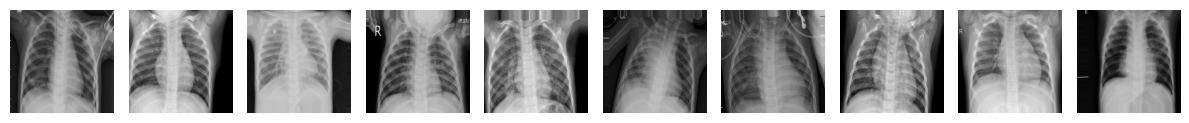

In [36]:
num_images_to_display = 10
fig, axes = plt.subplots(nrows=1, ncols=num_images_to_display, figsize=(12, 12))

for i in range(num_images_to_display):
    # Generate a batch of augmented images
    batch = next(train_generator)

    # Display the first image from the batch
    image = batch[0][0]
    axes[i].imshow(image)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

63/63 [==============================] - 26s 408ms/step


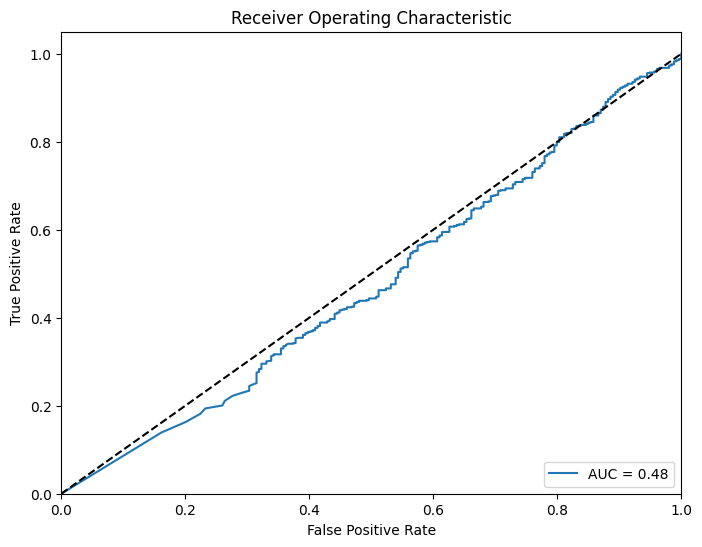

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
y_pred = model.predict(validation_generator)

fpr, tpr, _ = roc_curve(validation_generator.classes, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

74/74 [==============================] - 31s 415ms/step


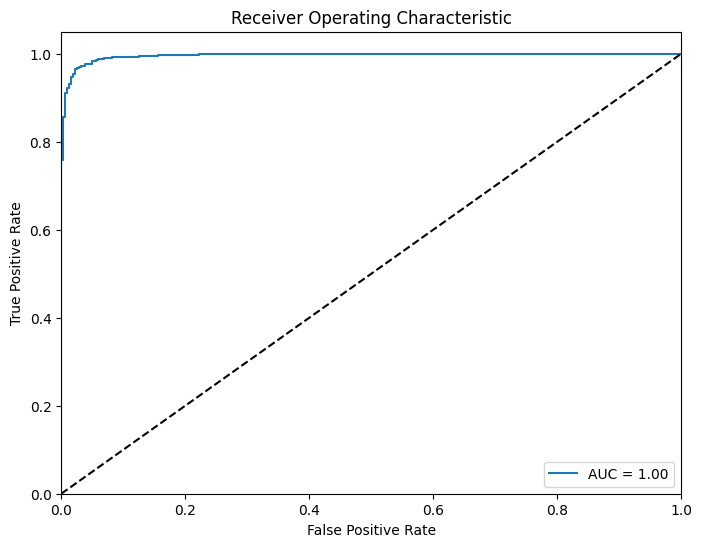

In [38]:
x_pred = model.predict(test_generator)
fpr, tpr, _ = roc_curve(test_generator.classes, x_pred)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()